In [1]:
! pip install -q torchcfm torchdyn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.4.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cudf 23.8.0 requir

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader
from torchcfm.models.unet import UNetModel
from torchcfm import ConditionalFlowMatcher
from torchdyn.core import NeuralODE
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

2024-05-03 12:53:27.685479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 12:53:27.685576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 12:53:27.814149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_df.drop("label", axis=1, inplace=True)

train_data = train_df.values

In [4]:
train_data = train_data / 255
train_data = (train_data - 0.5) / 0.5
train_data = torch.tensor(train_data, dtype=torch.float32)
train_data = train_data.reshape(-1, 1, 28, 28)

In [5]:
trainset = TensorDataset(train_data)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=0.0)

In [7]:
num_epochs = 5
num_steps = num_epochs * len(train_loader)

pbar = tqdm(total=num_steps)
losses = []

for epoch in range(num_epochs):
    for (data,) in train_loader:
        x1 = data.to(device)
        x0 = torch.randn_like(x1)
        
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        
        loss = F.mse_loss(vt, ut)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        pbar.update()
        
pbar.close()

  0%|          | 0/1645 [00:00<?, ?it/s]

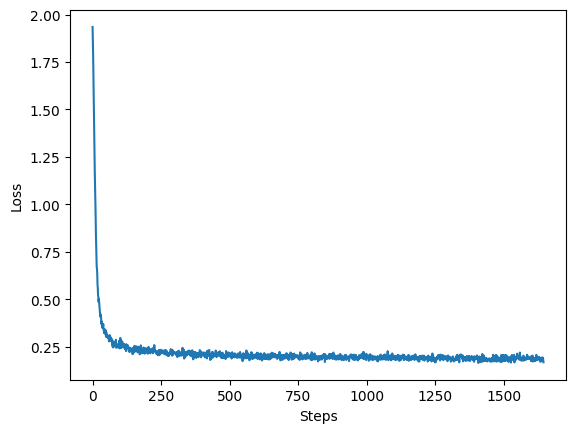

In [8]:
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

In [9]:
solver = NeuralODE(model, sensitivity='adjoint', solver='dopri5').to(device)

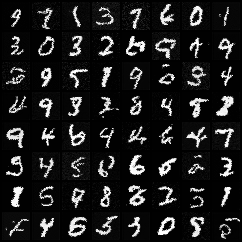

In [10]:
num_samples = 64
nfe = 100
t_span = torch.linspace(0, 1, nfe)

x0 = torch.randn(num_samples, 1, 28, 28, device=device)

with torch.no_grad():
    t_eval, trajectory = solver(x0, t_span)
    
x1 = trajectory[-1]
x1 = torch.clamp(x1, min=-1., max=1.)

ToPILImage()(make_grid(x1, nrow=8))

## To-DO

- [ ] Evaluate sample generation qualitiy (e.g. NLL, FID)